# Imports

In [2]:
import torch
from torch import optim, nn
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

import sys
sys.path.append('..')
from model_main import Unet
from  custom_dataset import CustomDataset

# Params & Dataset

In [5]:
IMG_SHAPE = (32,32)
X_PATH = "../data/train/"
Y_PATH = "../data/train_masks/"
X_TEST_PATH = "../data/manual_test/"
Y_TEST_PATH = "../data/manual_test_masks/"
MODEL_SAVE_PATH = "../models/unet.pth"
FEATS = [32]

LEARNING_RATE = 3e-3
BATCH_SIZE = 32
EPOCHS = 2
device = "cuda" if torch.cuda.is_available() else "cpu"

transform = transforms.Compose([
    transforms.Resize(IMG_SHAPE),
    transforms.ToTensor()
    ])
train_dataset = CustomDataset(X_path=X_PATH, Y_path=Y_PATH, transform=transform)
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2], generator=generator)

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

tensor([[[0.9176, 0.9176, 0.9176,  ..., 0.9529, 0.9529, 0.9569],
         [0.9137, 0.9137, 0.9137,  ..., 0.9529, 0.9529, 0.9569],
         [0.9137, 0.9098, 0.9098,  ..., 0.9490, 0.9490, 0.9529],
         ...,
         [0.7608, 0.7608, 0.7569,  ..., 0.7647, 0.7647, 0.7647],
         [0.7922, 0.7804, 0.7725,  ..., 0.7647, 0.7647, 0.7647],
         [0.8471, 0.8353, 0.8235,  ..., 0.7843, 0.7922, 0.8000]],

        [[0.9020, 0.9020, 0.9020,  ..., 0.9451, 0.9490, 0.9529],
         [0.8980, 0.8980, 0.8980,  ..., 0.9451, 0.9451, 0.9451],
         [0.8980, 0.8941, 0.8941,  ..., 0.9373, 0.9412, 0.9412],
         ...,
         [0.7412, 0.7412, 0.7373,  ..., 0.7608, 0.7608, 0.7608],
         [0.7804, 0.7686, 0.7569,  ..., 0.7608, 0.7608, 0.7608],
         [0.8314, 0.8196, 0.8118,  ..., 0.7843, 0.7882, 0.7961]],

        [[0.9059, 0.9059, 0.9059,  ..., 0.9686, 0.9686, 0.9725],
         [0.9020, 0.9020, 0.9020,  ..., 0.9647, 0.9647, 0.9647],
         [0.8980, 0.8980, 0.8941,  ..., 0.9451, 0.9490, 0.

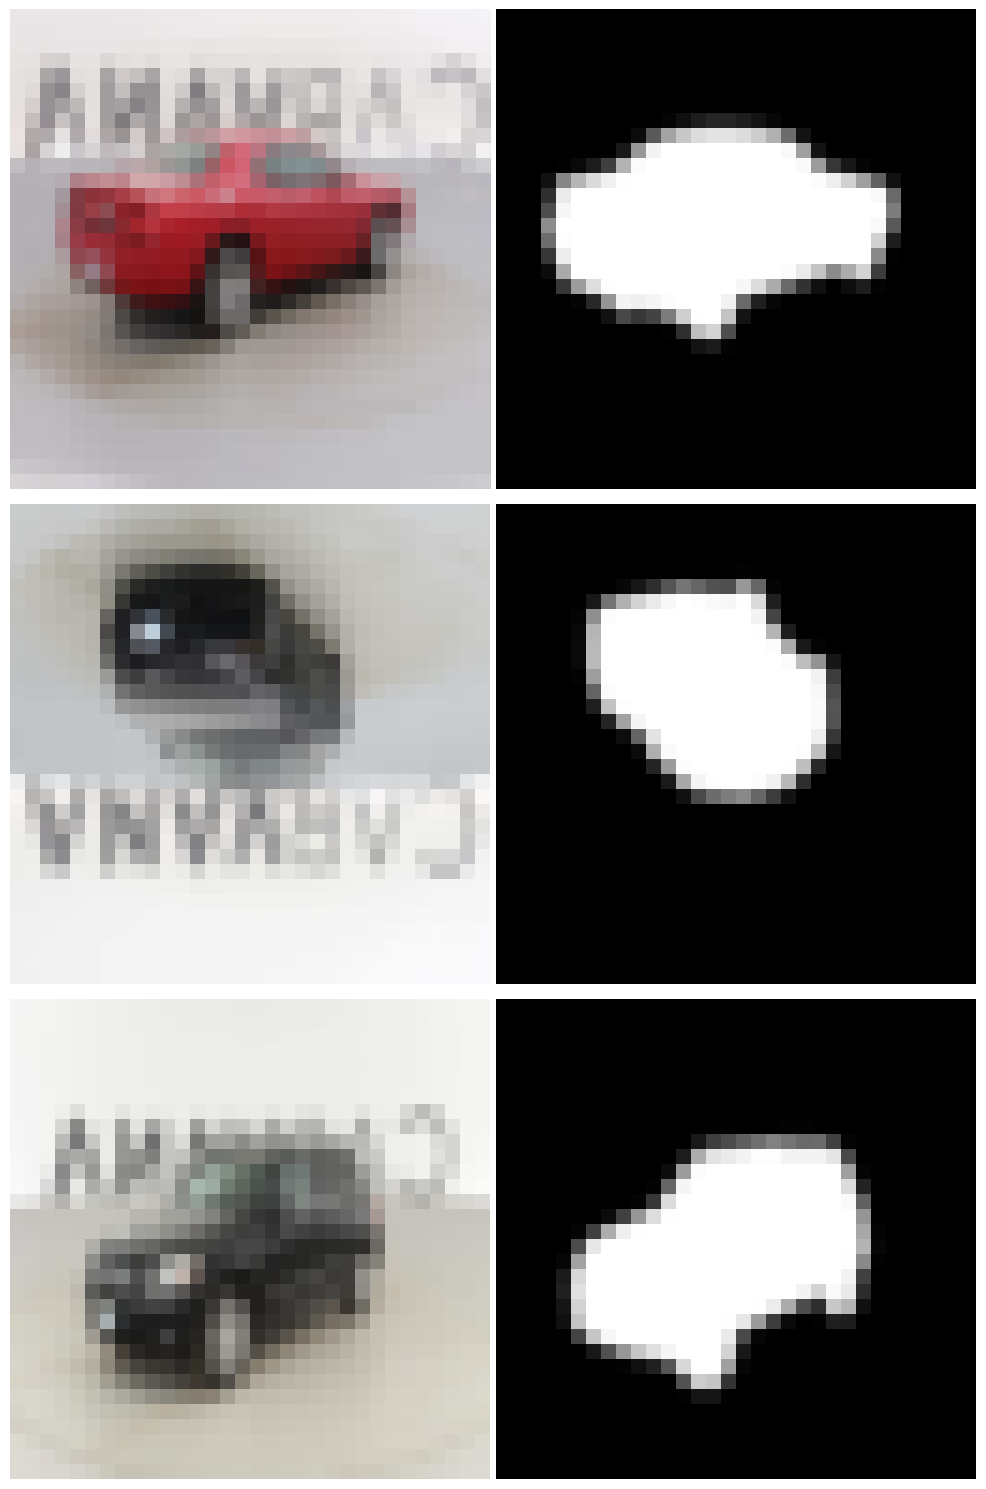

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'train_dataset' is your dataset instance
fig, axs = plt.subplots(3, 2, figsize=(10, 15))  # 3 rows, 2 columns

for i in range(3):
    image, mask = train_dataset[i] # Convert to numpy array
    print(image.float().to(device))
    #mask = train_dataset[i][1].numpy()  # Convert to numpy array
    #print("j")

    # Rearrange channels to [height, width, 3]
    image = np.transpose(image, (1, 2, 0))
    mask = np.transpose(mask, (1, 2, 0))
    
    # Assuming the mask needs to be visualized as grayscale
    # If the mask is already repeated across 3 channels and looks fine, you can skip this
    # mask = mask[:, :, 0]  # Uncomment if you want to display the mask as grayscale

    axs[i, 0].imshow(image)
    axs[i, 1].imshow(mask, cmap='gray')  # Use cmap='gray' if displaying the mask as grayscale
    
    # Remove axes for a cleaner look
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

# Model

In [7]:
model = Unet(in_channels=3, out_channels=1, feats=FEATS).to(device=device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

# Lets Train

In [5]:
for epoch in tqdm(range(EPOCHS)):
    model.train()
    train_running_loss = 0
    for idx, img_mask in enumerate(tqdm(train_dataloader)):
        img, mask = img_mask
        img = img.float().to(device)
        mask = mask.float().to(device)
        
        y_pred = model(img)
        optimizer.zero_grad()
        loss = criterion(y_pred, mask)
        train_running_loss += loss.item()

        loss.backward()
        optimizer.step()
    train_loss = train_running_loss / idx+1

    model.eval()
    val_running_loss = 0
    with torch.no_grad():
        for idx, img_mask in enumerate(tqdm(val_dataloader)):
            img, mask = img_mask
            img = img.float().to(device)
            mask = mask.float().to(device)

            y_pred = model(img)
            loss = criterion(y_pred, mask)

            val_running_loss += loss.item()
        val_loss = val_running_loss / idx+1
    
    print(f"Ep:{epoch+1} Train_loss:{train_loss:.4f} Val_loss:{val_loss:.4f}")

 50%|█████     | 1/2 [02:28<02:28, 148.49s/it]

Ep:1 Train_loss:1.1556 Val_loss:1.1151


100%|██████████| 2/2 [04:53<00:00, 146.78s/it]

Ep:2 Train_loss:1.0686 Val_loss:1.0663


In [8]:
torch.save(model.state_dict(), MODEL_SAVE_PATH)

# Inference

In [9]:
model = Unet(in_channels=3, out_channels=1, feats=FEATS).to(device)
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=torch.device(device)))
test_dataset = CustomDataset(X_path=X_TEST_PATH, Y_path=Y_TEST_PATH, transform=transform)
images = []
orig_masks = []
pred_masks = []

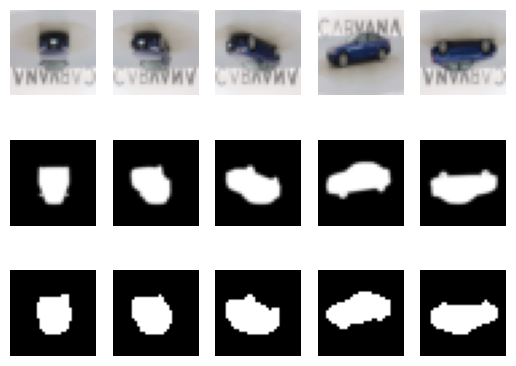

In [ ]:
for img, orig_mask in test_dataset:
    img = img.float().to(device)
    img = img.unsqueeze(0)

    pred_mask = model(img)

    img = img.squeeze(0).cpu().detach()
    img = img.permute(1, 2, 0)

    pred_mask = pred_mask.squeeze(0).cpu().detach()
    pred_mask = pred_mask.permute(1, 2, 0)
    pred_mask[pred_mask < 0]=0
    pred_mask[pred_mask > 0]=1

    orig_mask = orig_mask.cpu().detach()
    orig_mask = orig_mask.permute(1, 2, 0)

    images.append(img)
    orig_masks.append(orig_mask)
    pred_masks.append(pred_mask)

images.extend(orig_masks)
images.extend(pred_masks)
fig = plt.figure()
for i in range(1, 3*len(test_dataset)+1):
    fig.add_subplot(3, len(test_dataset), i)
    plt.imshow(images[i-1], cmap="gray")
    plt.axis('off')
plt.savefig('figureout.png', bbox_inches='tight')  # `bbox_inches='tight'` removes extra white spaces around the figure.

#plt.show()